In [1]:
!pip install datasets
!pip install --upgrade tensorflow
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 77.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer,

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential

import keras 
import sys, time, os, warnings
import numpy as np
import pandas as pd
from collections import Counter
warnings.filterwarnings('ignore')
import os

import datasets


from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import io, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import Seq2SeqTrainer ,Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel , ViTFeatureExtractor
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator


if torch.cuda.is_available():    

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: Tesla T4


In [3]:
os.environ["WANDB_DISABLED"] = "true"
class config : 
    ENCODER = "google/vit-base-patch16-224"
    DECODER = "gpt2"
    TRAIN_BATCH_SIZE = 8
    VAL_BATCH_SIZE = 8
    VAL_EPOCHS = 1
    LR = 5e-5
    SEED = 42
    MAX_LEN = 128
    SUMMARY_LEN = 20
    WEIGHT_DECAY = 0.01
    MEAN = (0.485, 0.456, 0.406)
    STD = (0.229, 0.224, 0.225)
    TRAIN_PCT = 0.95
    NUM_WORKERS = mp.cpu_count()
    EPOCHS = 3
    IMG_SIZE = (224,224)
    LABEL_MASK = -100
    TOP_K = 1000
    TOP_P = 0.95

In [4]:
## The location of the Flickr8K_ images
dir_Flickr_jpg = "/kaggle/input/flickr8k/Images"
## The location of the caption file
dir_Flickr_text = "/kaggle/input/hashcaption/Flickr8k.lemma.token.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))


The number of jpg flies in Flicker8k: 8091


## Finding captions for each image

In [5]:
#Finding the captions for each image.
file = open(dir_Flickr_text,'r', encoding='utf8')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#") # Splitting the caption dataset at the required position
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])


uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.filename.values).values())
print(df_txt[:5])

The number of unique file names : 8092
The distribution of the number of captions for each image:
                    filename index  \
0  1305564994_00513f9a5b.jpg     0   
1  1305564994_00513f9a5b.jpg     1   
2  1305564994_00513f9a5b.jpg     2   
3  1305564994_00513f9a5b.jpg     3   
4  1305564994_00513f9a5b.jpg     4   

                                             caption  
0  a man in street racer armor be examine the tir...  
1         two racer drive a white bike down a road .  
2  two motorist be ride along on their vehicle th...  
3  two person be in a small race car drive by a g...  
4       two person in race uniform in a street car .  


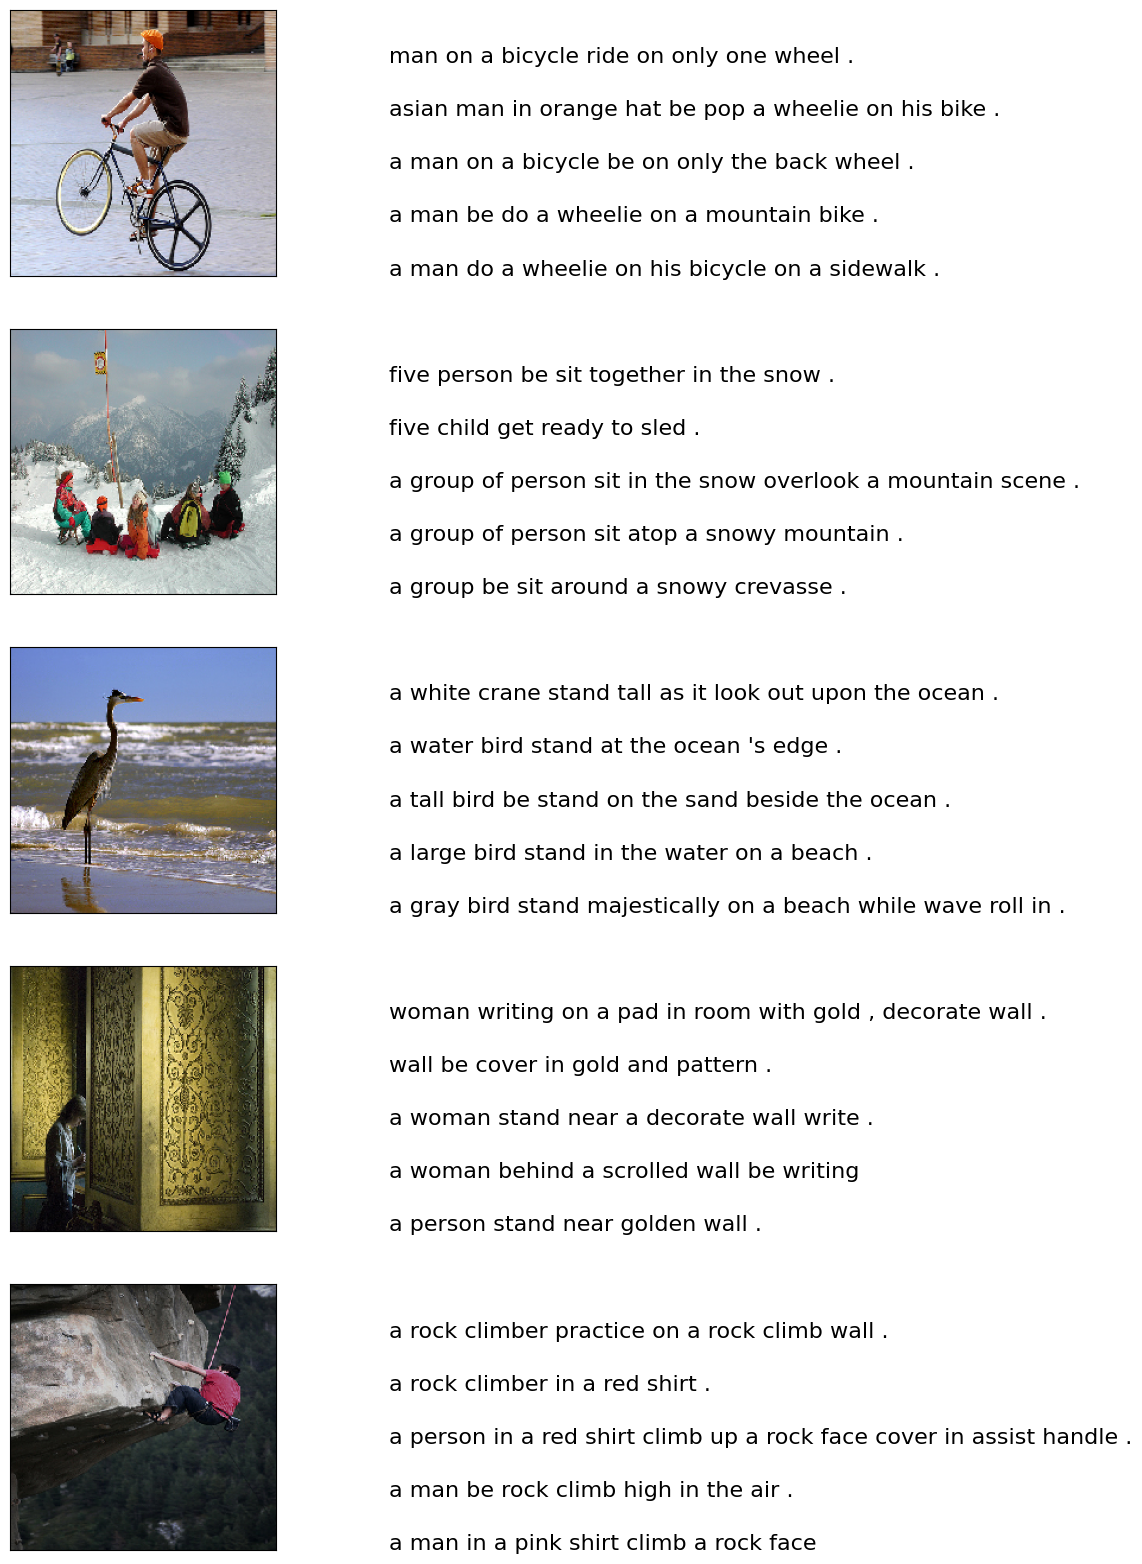

In [6]:
from keras.preprocessing.image import load_img, img_to_array
from IPython.display import display
from PIL import Image

npic = 5  # Displaying 5 images from the dataset
npix = 224
target_size = (npix, npix, 3)

count = 1 
fig = plt.figure(figsize=(10,20))

for jpgfnm in uni_filenames[-5:]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic, 2 , count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0, len(captions))
    for i, caption in enumerate(captions):
        ax.text(0, i, caption, fontsize=16)
    count += 1
plt.show() 

## Caption cleaning

In [7]:
# Defining a function to calculate the top 5 words in all the captions available for the images
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({'word':list(ct.keys()), "count":list(ct.values())})
    dfword = dfword.sort_values("count", ascending=False)
    dfword = dfword.reset_index()[["word", "count"]]
    
    return (dfword)

dfword = df_word(df_txt)
dfword.head()

Vocabulary Size: 6778


,word,count
0,a,69581
1,.,36579
2,in,18975
3,be,13268
4,on,10746


In [8]:
import string
text_original = "I ate 8 burgers and 4 pizzas. it's 9:44 am. can you play chess with me"

print("Origial sentense: ",text_original)
print("\nRemoving Punctuations...")

# creating a function that removes punctuation in the sentences
def remove_punctuation(text_original):
    text_without_punct = text_original.translate(str.maketrans('','',string.punctuation))
    return text_without_punct

text_without_punct = remove_punctuation(text_original)
print(text_without_punct)

print("\nRemoving a single character...")

# creating a function that removes single character
def removing_single_char(text):
    text_len_greater_than_one = ""
    for word in text.split():
        if len(word) > 1:
            text_len_greater_than_one += " " + word
    return text_len_greater_than_one

text_len_greater_than_one = removing_single_char(text_without_punct)
print(text_len_greater_than_one)

print("\nRemoving numeric values...")

# creating a function that removes numerical values
def remove_numeric(text, printTF=False):
    text_without_num = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("     {:10} : {:}".format(word, isalpha))
        if isalpha:
            text_without_num += " "+ word
    return text_without_num

text_without_num = remove_numeric(text_len_greater_than_one, printTF=True)
print(text_without_num)

Origial sentense:  I ate 8 burgers and 4 pizzas. it's 9:44 am. can you play chess with me

Removing Punctuations...
I ate 8 burgers and 4 pizzas its 944 am can you play chess with me

Removing a single character...
 ate burgers and pizzas its 944 am can you play chess with me

Removing numeric values...
     ate        : True
     burgers    : True
     and        : True
     pizzas     : True
     its        : True
     944        : False
     am         : True
     can        : True
     you        : True
     play       : True
     chess      : True
     with       : True
     me         : True
 ate burgers and pizzas its am can you play chess with me


In [9]:
def text_clean(text_original):
    
    text = remove_punctuation(text_original)
    text = removing_single_char(text)
    text = remove_numeric(text)
    
    return text

for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt['caption'].iloc[i] = newcaption

Vocabulary Size: 6686


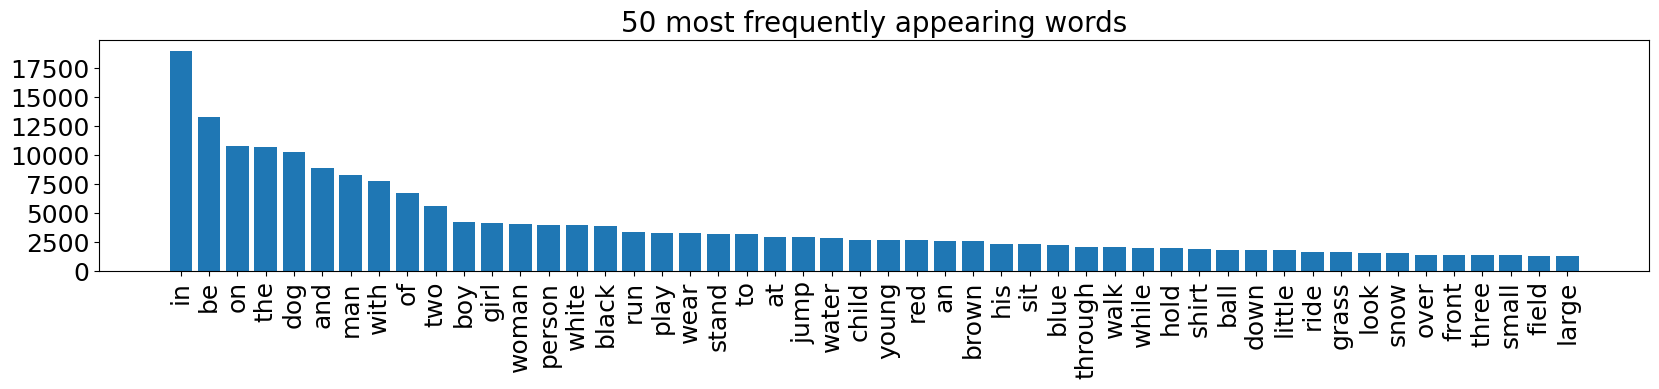

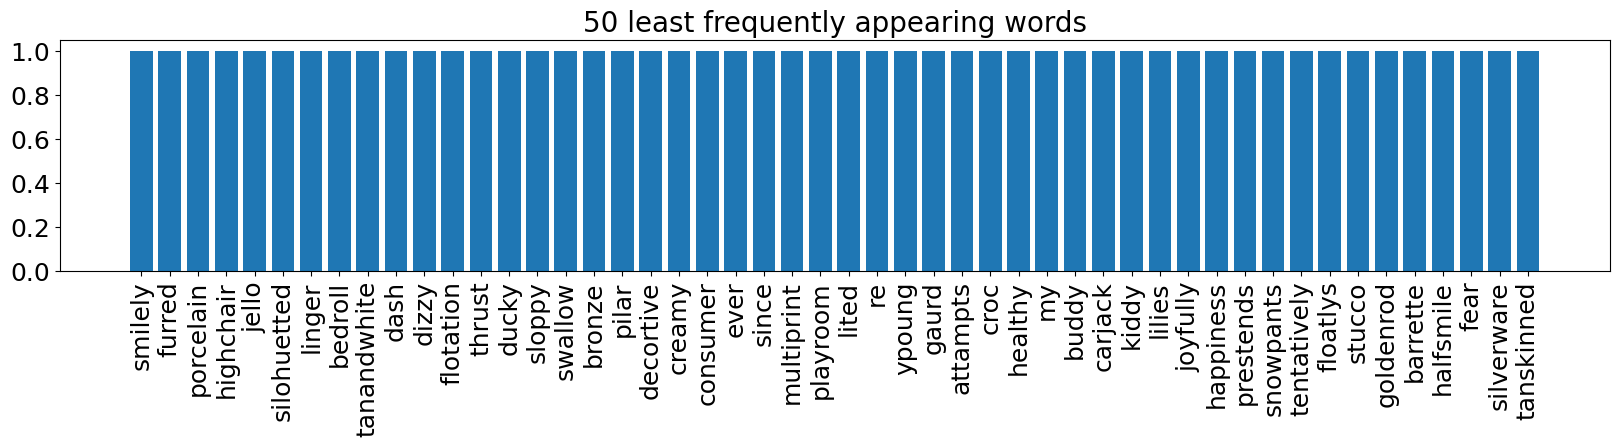

In [10]:
topn=50
def plthist(dfsub, title="Plotting top 50 words that occur in the Cleaned Dataset"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index, dfsub["count"])
    plt.yticks(fontsize=18)
    plt.xticks(dfsub.index, dfsub["word"], rotation=90, fontsize=18)
    plt.title(title, fontsize=20)
    plt.show()
    
dfword = df_word(df_txt)
plthist(dfword.iloc[:topn,:], title="50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:], title="50 least frequently appearing words")

In [11]:
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    """
    Build model inputs from a sequence or a pair of sequence for sequence classification tasks
    by concatenating and adding special tokens.
    """
    if token_ids_1 is None:
        inputs_ids = token_ids_0
    else:
        inputs_ids = token_ids_0 + self.sep_token_id + token_ids_1
    return inputs_ids
AutoTokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens

In [12]:
from IPython.display import clear_output
!pip install rouge_score -q
!pip install deep-phonemizer -q
clear_output()

In [13]:
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

In [14]:
feature_extractor = ViTFeatureExtractor.from_pretrained(config.ENCODER)
tokenizer = AutoTokenizer.from_pretrained(config.DECODER)
tokenizer.pad_token = tokenizer.unk_token

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [15]:
transforms = transforms.Compose(
    [
        transforms.Resize(config.IMG_SIZE), 
        transforms.ToTensor(),
        transforms.Normalize(
            mean=0.5, 
            std=0.5
        )
   ]
)
df=  pd.read_csv("/kaggle/input/flickr8k/captions.txt")
train_df , val_df = train_test_split(df , test_size = 0.2)
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [16]:
class ImgDataset(Dataset):
    def __init__(self, df,root_dir,tokenizer,feature_extractor, transform = None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.tokenizer= tokenizer
        self.feature_extractor = feature_extractor
        self.max_length = 50
    def __len__(self,):
        return len(self.df)
    def __getitem__(self,idx):
        caption = self.df.caption.iloc[idx]
        image = self.df.image.iloc[idx]
        img_path = os.path.join(self.root_dir , image)
        img = Image.open(img_path).convert("RGB")

        
        
        if self.transform is not None:
            img= self.transform(img)
        img = ((img + 1.0) * 255 / 2).to(torch.uint8)
        pixel_values = self.feature_extractor(img, return_tensors="pt").pixel_values
        captions = self.tokenizer(caption,
                                 padding='max_length',
                                 max_length=self.max_length).input_ids
        captions = [caption if caption != self.tokenizer.pad_token_id else -100 for caption in captions]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(captions)}
        return encoding

In [17]:
train_dataset = ImgDataset(train_df, root_dir = "/kaggle/input/flickr8k/Images",tokenizer=tokenizer,feature_extractor = feature_extractor ,transform = transforms)
val_dataset = ImgDataset(val_df , root_dir = "/kaggle/input/flickr8k/Images",tokenizer=tokenizer,feature_extractor = feature_extractor , transform  = transforms)

In [18]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(config.ENCODER, config.DECODER)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [19]:
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size
# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.max_length = 128
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [20]:
!pip install -U accelerate
!pip install -U transformers
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 34.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 36.9 MB/s eta 0:00:0000:01:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.39.3
    Uninstalling transformers-4.39.3:
      Successfully uninstalled transformers-4.39.3


In [21]:


training_args = Seq2SeqTrainingArguments(
    output_dir='VIT_large_gpt2',
    per_device_train_batch_size=config.TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=config.VAL_BATCH_SIZE,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=1024,  
    save_steps=2048, 
    warmup_steps=1024,  
    learning_rate = 5e-5,
    #max_steps=1500, # delete for full training
    num_train_epochs = config.EPOCHS, #TRAIN_EPOCHS
    overwrite_output_dir=True,
    save_total_limit=1,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


## Training using Seq2Seq trainer

In [22]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
1,3.141900,2.376036,0.030000,0.297900,0.053400
2,2.202400,2.201034,0.032800,0.325300,0.058700
3,1.861400,2.175118,0.034300,0.327800,0.060800


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Removed shared tensor {'decoder.lm_head.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no

TrainOutput(global_step=6069, training_loss=2.289630230538907, metrics={'train_runtime': 32867.915, 'train_samples_per_second': 2.954, 'train_steps_per_second': 0.185, 'total_flos': 1.7521600116635468e+19, 'train_loss': 2.289630230538907, 'epoch': 3.0})

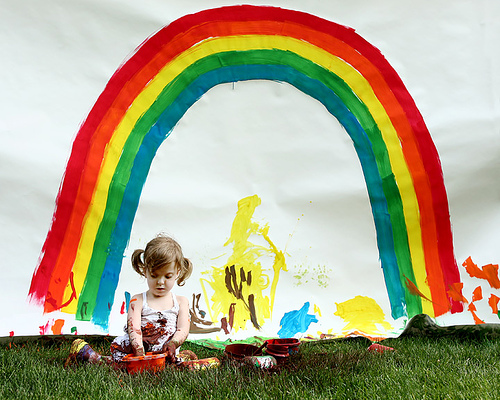

In [23]:
img =  Image.open("/kaggle/input/flickr8k/Images/1002674143_1b742ab4b8.jpg").convert("RGB")
img

In [24]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption[:120]+ '\033[0m')

<|endoftext|>A little girl is sitting in front of a painted picture of a rainbow. She is surrounded by colorful flowers.


###